In [1]:
suppressMessages(library("rwwa"))

In [6]:
gmst <- read.table("gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2025]

cov_2025 <- gmst[gmst$year == 2025,"gmst",drop = F]
cov_cf <- rbind("pi" = cov_2025 - 1.3, "2000" = cov_2025 - 0.65)

In [ ]:
# df <- read.csv("tx5x-monthly_era5_cities.csv")

# df$year <- as.integer(substr(df$time,1,4))
# df$month <- as.integer(substr(df$time,6,7))

In [186]:
m_rates <- rep(c(1,1,1,1,1,3,2,1,1,1,1,1), 76)
gmst_y <- rep(gmst$gmst[(gmst$year >= 1950) & (gmst$year <= 2025)], each = 12)
tmean <- 25 + gmst_y * m_rates

In [187]:
df <- data.frame(year = rep(1950:2025, each = 12),
                 t2m = revd(12*76, loc = tmean),
                 month = rep(1:12, 76))

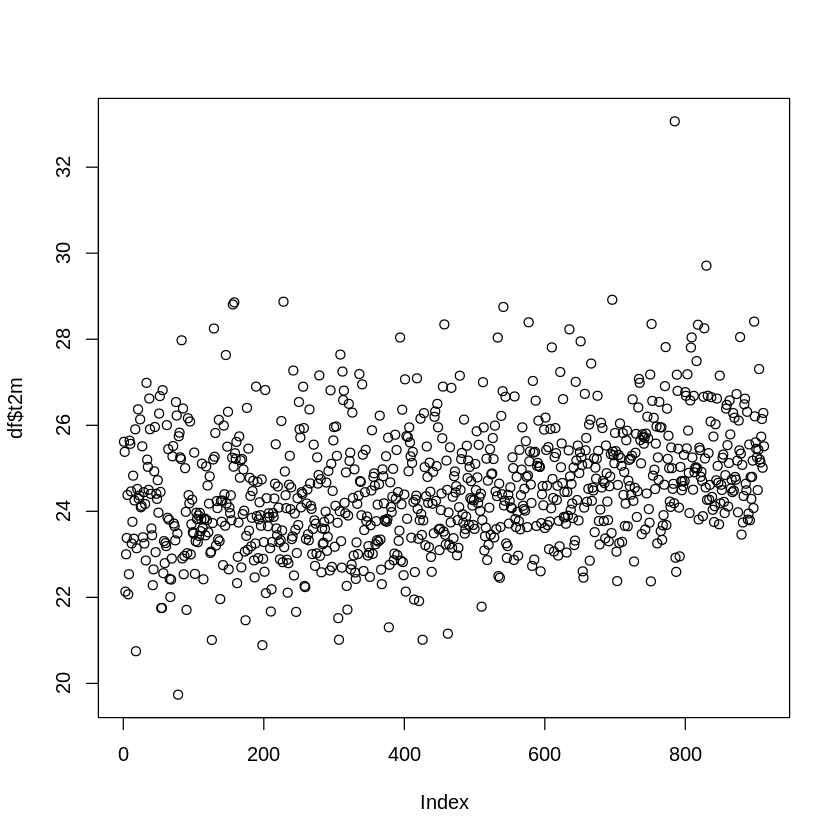

In [188]:
plot(df$t2m)

In [189]:
jj_res <- function(m_jun, m_jul) {
    res_6 <- mdl_ests(m_jun, cov_f = cov_2025, cov_cf = cov_cf)
    res_7 <- mdl_ests(m_jul, cov_f = cov_2025, cov_cf = cov_cf)
    c(setNames(res_6, paste0("jun_", names(res_6))), setNames(res_7, paste0("jul_", names(res_7))),
      res_6[grepl("dI_abs", names(res_6))] - res_7[grepl("dI_abs", names(res_7))],
      res_6[grepl("alpha_gmst", names(res_6))] - res_7[grepl("alpha_gmst", names(res_7))])
}

In [190]:
for(cnm in colnames(df)[-1][1]) {
    df_c <- merge(gmst, df[,c("year", "month", cnm)])
    
    df_jun <- df_c[df_c$month == 6,]
    df_jul <- df_c[df_c$month == 7,]
    
    mdl_jun <- fit_ns("gev", "shift", df_jun, varnm = cnm, covnm = "gmst", lower = F)
    mdl_jul <- fit_ns("gev", "shift", df_jul, varnm = cnm, covnm = "gmst", lower = F)

    obs_res <- jj_res(mdl_jun, mdl_jul)
    
    # bootstrap whole years to get difference in trends
    set.seed(42)
    boot_res <- sapply(1:500, function(i) {
        ysamp <- sample(1:nrow(df_c[df_c$month == 6,]), replace = T)
        boot_df_jun <- mdl_jun$data[ysamp, ]
        boot_df_jul <- mdl_jul$data[ysamp, ]
        tryCatch({
            boot_jun <- refit(mdl_jun, new_data = boot_df_jun)
            boot_jul <- refit(mdl_jul, new_data = boot_df_jul)
            jj_res(boot_jun, boot_jul)
        }, error = function(cond) {
            return(rep(NA, length(obs_res)))
        })
    })
    boot_res <- boot_res[,!is.na(boot_res["alpha_gmst",])]
}

In [191]:
write.csv(rbind("est" = obs_res, apply(boot_res,1,quantile,c(0.025,0.5,0.975), na.rm = T)),
          "compare-jun-july-change_tg5x_era5.csv")
write.csv(boot_res, "full-bootstrap_jun-july-change_tg5x_era5.csv")

In [192]:
res <- rbind("est" = obs_res, apply(boot_res,1,quantile,c(0.025,0.5,0.975), na.rm = T))

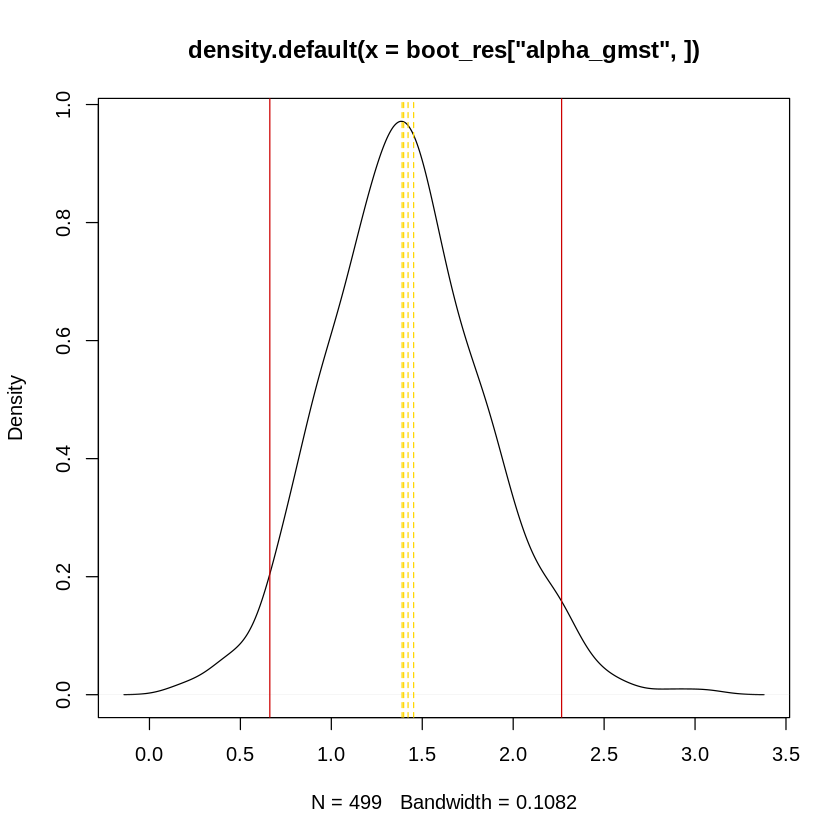

In [201]:
plot(density(boot_res["alpha_gmst",]))
abline(v = quantile(boot_res["alpha_gmst",], c(0.025, 0.975)),col = "red3")
abline(v = res[,"jun_alpha_gmst"] - res[,"jul_alpha_gmst"], lty = 2, col = "gold")

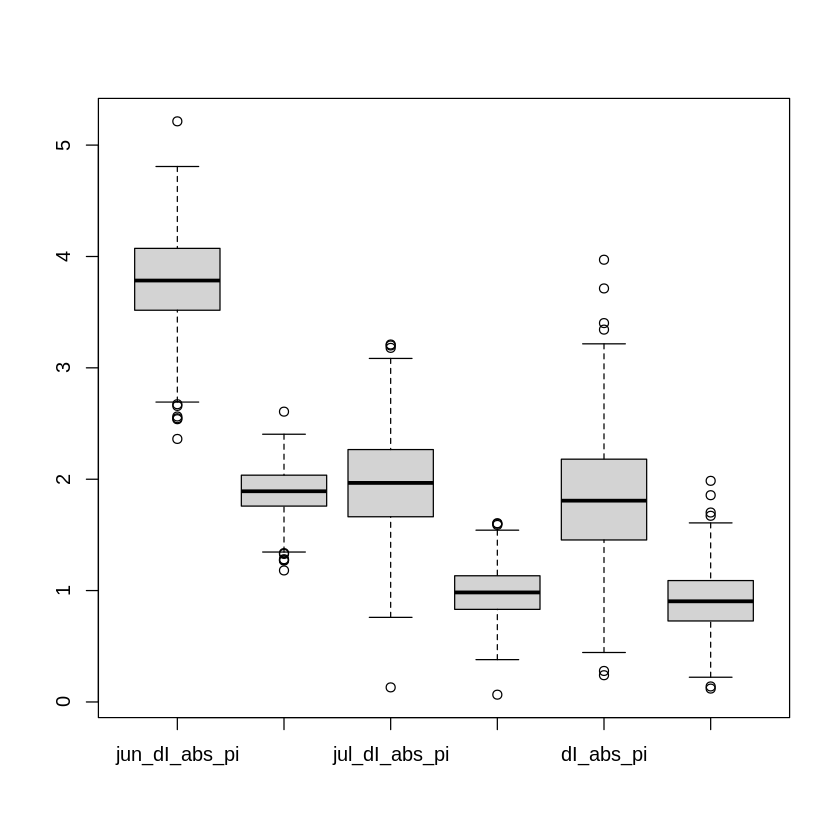

In [206]:
boxplot(t(boot_res[grepl("dI_abs", rownames(boot_res)),]))